# импортим людвига

In [2]:
!pip install https://github.com/uber/ludwig/archive/master.zip

  Using cached https://github.com/uber/ludwig/archive/master.zip
  Created wheel for ludwig: filename=ludwig-0.2.2.7-cp36-none-any.whl size=240599 sha256=bf3e633b68511e17904feae53da8d286947b2b82519e2646d9755db63f6d63dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lp1kdip/wheels/30/9f/b2/833552e09bd230b17320cedd21d54b49b40978673ae82b21e4
Successfully built ludwig


это кстати принципиальный момент: если открыть "../input" выпадет только главная папка а не подпапки

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import ludwig
from ludwig.api import LudwigModel
import scipy as scipy

import matplotlib.pyplot as plt
%matplotlib inline

['skin-cancer-mnist-ham10000']


In [5]:
from glob import glob

создаем словарик в котором картинке будет соответствовать ссылка на нее

In [6]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000', '*', '*.jpg'))}

In [7]:
imageid_path_dict

{'ISIC_0026858': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026858.jpg',
 'ISIC_0026869': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026869.jpg',
 'ISIC_0029033': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029033.jpg',
 'ISIC_0024459': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024459.jpg',
 'ISIC_0026918': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026918.jpg',
 'ISIC_0025000': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025000.jpg',
 'ISIC_0025557': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025557.jpg',
 'ISIC_0029094': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029094.jpg',
 'ISIC_0026340': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026340.jpg',
 'ISIC_0024522': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024

для упрощения восприятия делаем словарик который переводит болезни с новояза

In [8]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

закидываем в табличку ссылки и переведенные названия болезней

In [9]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2


## проверка качества данных

пытаемся засечь нули

In [11]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

неприкольно то, что несколько возрастов равно нулю. скорее всего это ошибка датасета и там должны стоять не нули, а na

мы поправим их из вежливости, хотя на самом деле нам это не надо совершенно

In [12]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [13]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

ура теперь датасет человеческий и без нулей

# лирическое отступление

людвигу в начале категорически не нравились ссылки на картинки, которыми я его кормлю. потому я решила покормить его картинками. картинки он не поел потому что тип данных он такой (а был разный - и строки, которые вроде как съедобными должны быть по словам мануала, и нампаевские массивы и вообще все) не любит, но код удалять жалко.

а потом я поменяла ссылки и все стало хорошо

заресайзим изображения под единый стандарт и закинем их в табличку

In [89]:
from PIL import Image

In [1]:
skin_df['image'] = skin_df['path'].map(lambda x: Image.open(x).resize((100,75)))

NameError: name 'skin_df' is not defined

# конец лирического отступления

переходим к самому обучению

In [14]:
from ludwig.api import LudwigModel


описываем то как будет работать моделька

In [15]:
# train a model
model_definition = {
    'input_features': [
        {'name': 'path',
         'type': 'image',
         'preprocessing':{'height': 128, 'width': 128, 
                                        'resize_method': 'interpolate', 'scaling': 'pixel_normalization'}
         }
    ],
    'output_features': [
        {'name': 'cell_type', 'type': 'category'}
    ]
}
model = LudwigModel(model_definition)

по-хорошему надо было прогнать на всем массиве. тогда получились бы реальные и толковые результаты. но на это у kaggle не хватает сил, а у меня времени. потому прогоняю на первых 100 - это не покажет какие-то значимые стат. результаты (хотя бы потому, что, исходя из показанной на втором графике точности, в этот срез первых ста попал только один тип рака), но как минимум докажет то, что алгоритм работает))))

In [23]:
train_stats = model.train(skin_df[:][:100])

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## визуализация

In [24]:
from ludwig.visualize import *

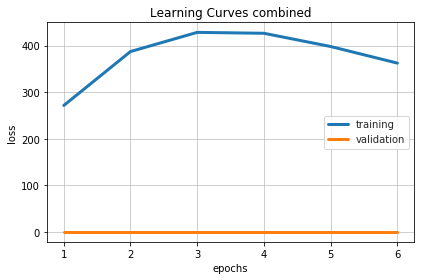

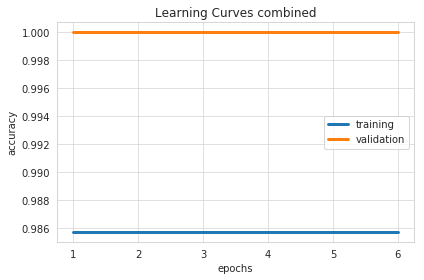

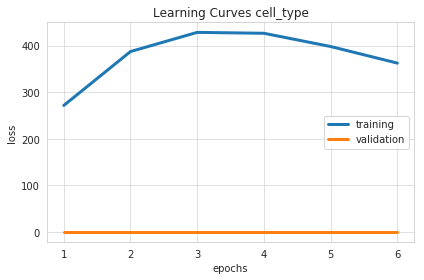

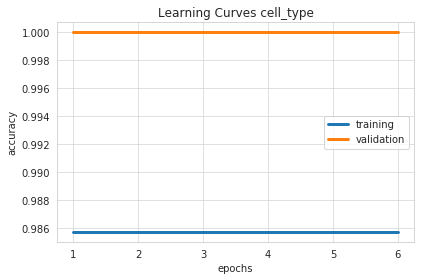

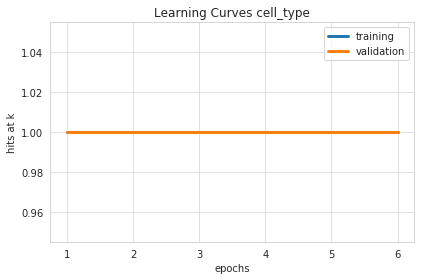

In [25]:
learning_curves(train_stats, 'state')

и - сейчас будет очень неожиданно! - предсказывает по первым 100 он точно

In [32]:
predictions = model.predict(skin_df[:][:10])

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [33]:
predictions.head()

,cell_type_predictions,cell_type_probabilities_<UNK>,cell_type_probabilities_Benign keratosis-like lesions,cell_type_probabilities_Melanocytic nevi,cell_type_probability
0,Benign keratosis-like lesions,0.0,1.0,0.0,1.0
1,Benign keratosis-like lesions,0.0,1.0,0.0,1.0
2,Benign keratosis-like lesions,0.0,1.0,0.0,1.0
3,Benign keratosis-like lesions,0.0,1.0,0.0,1.0
4,Benign keratosis-like lesions,0.0,1.0,0.0,1.0
